In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from datashader.bundling import hammer_bundle  # key for bundling
from scipy.stats import gaussian_kde  # key for coloring hot bundles

plt.rc('axes', axisbelow=True)

%matplotlib inline

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def bundle_edges(G, pos='spring', max_segment_length=0.016, min_segment_length=0.008,
                 decay=0.7, initial_bandwidth=0.05, density=True, log_color=True):
    """
    Creates a dataframe of points that correspond to the paths/positions
    of the bundled edges of a network. The key step is to turn edges into points
    along a path and apply an attractive force to those points using a
    hammer_bundle function from the datashader packat
    
        url: {https://datashader.org/user_guide/Networks.html}
        
    Parameters for the hammer_bundle function:
        #############################################################
        # Name                  Value      Type      Bounds      Mode  
        #############################################################
        # accuracy               500     Integer   (1, None)     V RW  
        # advect_iterations       50     Integer   (0, None)     V RW  
        # batch_size            20000    Integer   (1, None)     V RW  
        # decay                  0.7      Number   (0.0, 1.0)    V RW  
        # include_edge_id       False    Boolean     (0, 1)      V RW  
        # initial_bandwidth      0.05     Number  (0.0, None)    V RW  
        # iterations              4      Integer   (1, None)     V RW  
        # max_segment_length    0.016     Number   (0, None)     V RW  
        # min_segment_length    0.008     Number   (0, None)     V RW  
        # source               'source'   String                 V RW  
        # target               'target'   String                 V RW  
        # tension                0.3      Number   (0, None)     V RW  
        # weight               'weight'   String               V RW AN 
        # x                      'x'      String                 V RW  
        # y                      'y'      String                 V RW  
        #############################################################

    Parameters
    ----------
    G (nx.Graph or DiGraph):
        the network in question

    pos (dict):
        if the nodes are already assigned positions (i.e. if the nodes
        are geographic in nature like cities, etc.), it uses those; else it
        uses one of the networkx layout algorithms to assign positions to them;
        currently works with 'spring' and 'kamada_kawai'

    max_segment_length (float: (0,None)):
        max number of scatter points per path

    min_segment_length (float: (0,None)):
        min number of scatter points per path

    decay (float: (0.0,1.0)):
        how much the strength of attraction decays with distance

    initial_bandwidth (float (0.0,None)):
        how far separated the initial scatter points are

    density (bool):
        if True, this will assign a color column to the output dataframe, coloring
        the resulting edge bundle based on density
        
    log_color (bool):
        if True, the color of the density will be based on a log scale, spreading
        the color out rather than being concentrated solely at the center.
    
    Returns
    -------
    hb (pd.DataFrame):
        dataframe with ['x','y'] and 'color' if density==True, corresponding to the
        positions of the scatter points, with NaNs separating different edges; can
        plot with either plt.scatter and get some points or plt.plot and get lines

    """
    
    # prepare pos dict for nodes
    if type(pos)!=dict:
        if pos == 'string':
            pos = nx.spring_layout(G)
        if pos == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(G)
        else:
            pos = nx.spring_layout(G)

    # get nodes dataframe ready
    nodes_py = [[name, a[0], a[1]] for name, a in pos.items()]
    ds_nodes = pd.DataFrame(nodes_py, columns=['name', 'x', 'y'])
    ds_nodes['name'] = ds_nodes['name'].astype(str)
    ds_nodes = ds_nodes.sort_values('name')
    ds_nodes['num'] = list(range(ds_nodes.shape[0]))    
    mapping = ds_nodes[['name','num']]
    mapping_dict = dict(zip(ds_nodes['name'],ds_nodes['num']))

    # get edges dataframe ready
    ds_edges_py = [[n0, n1] for (n0, n1) in G.edges]
    ds_edges = pd.DataFrame(ds_edges_py, columns=['source', 'target']).astype(str)
    ds_edges['source_num'] = [mapping_dict[i] for i in ds_edges['source']]
    ds_edges['target_num'] = [mapping_dict[i] for i in ds_edges['target']]

    # get inputs ready for hammer bundle
    ds_e = ds_edges[['source_num','target_num']]
    ds_e.columns = ['source','target']
    ds_n = ds_nodes[['num','x','y']]
    ds_n.columns = ['name','x','y']

    # key step: hammer bundle
    hb = hammer_bundle(ds_n, ds_e,
                       max_segment_length=max_segment_length, 
                       min_segment_length=min_segment_length,
                       decay=decay, 
                       initial_bandwidth=initial_bandwidth)

    if not density:
        return hb, pos
    
    else:
        xy = np.vstack([hb.dropna()['x'], hb.dropna()['y']])
        z = gaussian_kde(xy)(xy)
        
        if log_color:
            zcol = np.log(z)-min(np.log(z))
        else:
            zcol = z.copy()
        
        hb.loc[~((hb['x'].isna())&(hb['y'].isna())),'color'] = zcol

        return hb, pos

## Proof of concept

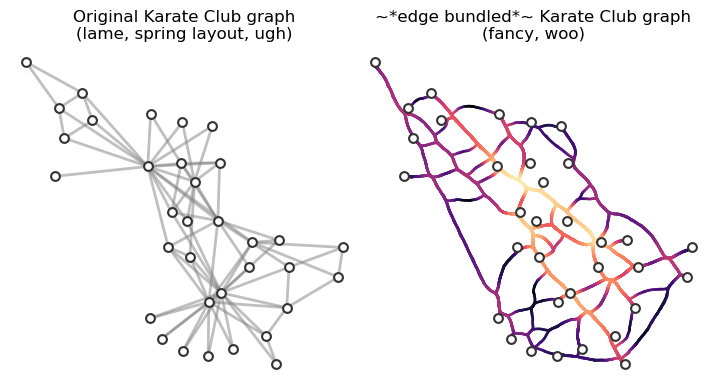

In [3]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G, seed=5)

hb, pos = bundle_edges(G, pos=pos, max_segment_length=0.005, min_segment_length=0.002, log_color=True)

ncols = 2
nrows = 1

fig, ax = plt.subplots(nrows,ncols,figsize=(ncols*4.5,nrows*4.4),dpi=100)
plt.subplots_adjust(hspace=0.15,wspace=0.0)

nx.draw_networkx_nodes(G, pos, node_color='w', edgecolors='.2',
                       zorder=20, node_size=40, ax=ax[0], linewidths=1.5)
nx.draw_networkx_edges(G, pos, edge_color='.5', width=2, alpha=0.5, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Original Karate Club graph\n(lame, spring layout, ugh)')

nx.draw_networkx_nodes(G, pos, node_color='w', edgecolors='.2',
                       zorder=20, node_size=40, ax=ax[1], linewidths=1.5)
ax[1].scatter(hb['x'], hb['y'], s=4, lw=0, c=(hb['color'])**1.15,
           cmap='magma', vmax=hb['color'].max()*1.25, alpha=0.95,zorder=0)
ax[1].set_axis_off()
ax[1].set_title("~*edge bundled*~ Karate Club graph\n(fancy, woo)")

plt.savefig('../figs/pngs/edge_bundle_karate.png', dpi=600, bbox_inches='tight')

plt.show()

In [4]:
G = nx.random_geometric_graph(45, 0.225)
while not nx.is_connected(G):
    G = nx.random_geometric_graph(45, 0.225)

pos = nx.kamada_kawai_layout(G)

hb, pos = bundle_edges(G, pos=pos, max_segment_length=0.005, min_segment_length=0.002, log_color=True)

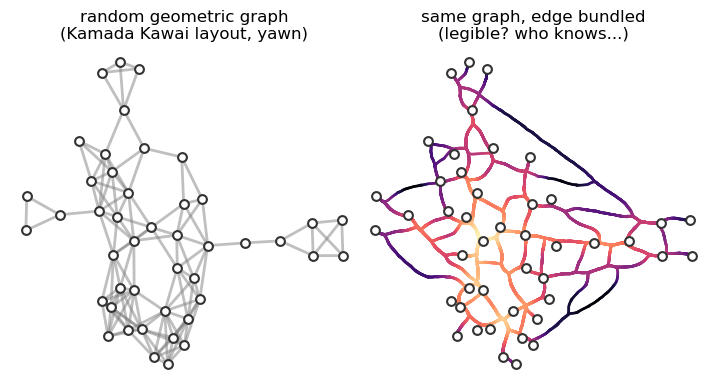

In [5]:
ncols = 2
nrows = 1

fig, ax = plt.subplots(nrows,ncols,figsize=(ncols*4.5,nrows*4.4),dpi=100)
plt.subplots_adjust(hspace=0.15,wspace=0.0)

nx.draw_networkx_nodes(G, pos, node_color='w', edgecolors='.2',
                       zorder=20, node_size=40, ax=ax[0], linewidths=1.5)
nx.draw_networkx_edges(G, pos, edge_color='.5', width=2, alpha=0.5, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title("random geometric graph\n(Kamada Kawai layout, yawn)")

nx.draw_networkx_nodes(G, pos, node_color='w', edgecolors='.2',
                       zorder=20, node_size=40, ax=ax[1], linewidths=1.5)
ax[1].scatter(hb['x'], hb['y'], s=4, lw=0, c=(hb['color'])**1.15,
           cmap='magma', vmax=hb['color'].max()*1.25, alpha=0.95,zorder=0)
ax[1].set_axis_off()
ax[1].set_title("same graph, edge bundled\n(legible? who knows...)")

plt.savefig('../figs/pngs/edge_bundle_rgg.png', dpi=600, bbox_inches='tight')

plt.show()

## Explore parameters

In [6]:
import itertools as it
import datetime as dt
hbs = []
pss = []
G_s = []
decays = np.linspace(0.05, 0.95, 6).round(2)
ibs    = np.logspace(-1, 0, 6).round(4)
ma_sl = 0.006
mi_sl = 0.003

xi = 0
for ibi in ibs:
    for di in decays:
        G = nx.random_geometric_graph(40, 0.25)
        while not nx.is_connected(G):
            G = nx.random_geometric_graph(40, 0.25)

#         pos = nx.spring_layout(G)
        pos = nx.kamada_kawai_layout(G)
        hb_i, posi = bundle_edges(G, pos=pos, 
                                  max_segment_length=ma_sl,
                                  min_segment_length=mi_sl,
                                  decay=di,
                                  initial_bandwidth=ibi, log_color=True)
        hbs.append(hb_i)
        pss.append(posi)
        G_s.append(G)
        xi += 1
        print("%02i"%xi, hb_i.shape, dt.datetime.now())

01 (24194, 3) 2020-05-26 11:03:56.552727
02 (25794, 3) 2020-05-26 11:04:04.152429
03 (27330, 3) 2020-05-26 11:04:13.828849
04 (23753, 3) 2020-05-26 11:04:21.053989
05 (27808, 3) 2020-05-26 11:04:31.216475
06 (24933, 3) 2020-05-26 11:04:38.866067
07 (20351, 3) 2020-05-26 11:04:43.860872
08 (24134, 3) 2020-05-26 11:04:50.979222
09 (29326, 3) 2020-05-26 11:05:02.350273
10 (29605, 3) 2020-05-26 11:05:13.738261
11 (22857, 3) 2020-05-26 11:05:20.819537
12 (30639, 3) 2020-05-26 11:05:33.391745
13 (22023, 3) 2020-05-26 11:05:39.580032
14 (20245, 3) 2020-05-26 11:05:45.229809
15 (27876, 3) 2020-05-26 11:05:55.969020
16 (25173, 3) 2020-05-26 11:06:04.410328
17 (20126, 3) 2020-05-26 11:06:10.206024
18 (25827, 3) 2020-05-26 11:06:19.382425
19 (28482, 3) 2020-05-26 11:06:29.676081
20 (29595, 3) 2020-05-26 11:06:40.808222
21 (22625, 3) 2020-05-26 11:06:47.895879
22 (21229, 3) 2020-05-26 11:06:54.106016
23 (27434, 3) 2020-05-26 11:07:04.173735
24 (22906, 3) 2020-05-26 11:07:12.030749
25 (24443, 3) 20

00 2020-05-26 11:08:51.750287
01 2020-05-26 11:08:51.763315
02 2020-05-26 11:08:51.777498
03 2020-05-26 11:08:51.791197
04 2020-05-26 11:08:51.806600
05 2020-05-26 11:08:51.822246
06 2020-05-26 11:08:51.835895
07 2020-05-26 11:08:51.847917
08 2020-05-26 11:08:51.860134
09 2020-05-26 11:08:51.873114
10 2020-05-26 11:08:51.886086
11 2020-05-26 11:08:51.899174
12 2020-05-26 11:08:51.913699
13 2020-05-26 11:08:51.925788
14 2020-05-26 11:08:51.937493
15 2020-05-26 11:08:51.950253
16 2020-05-26 11:08:51.964136
17 2020-05-26 11:08:52.098489
18 2020-05-26 11:08:52.114547
19 2020-05-26 11:08:52.129949
20 2020-05-26 11:08:52.143802
21 2020-05-26 11:08:52.155550
22 2020-05-26 11:08:52.167716
23 2020-05-26 11:08:52.181514
24 2020-05-26 11:08:52.195001
25 2020-05-26 11:08:52.208822
26 2020-05-26 11:08:52.222611
27 2020-05-26 11:08:52.236189
28 2020-05-26 11:08:52.249142
29 2020-05-26 11:08:52.261302
30 2020-05-26 11:08:52.275615
31 2020-05-26 11:08:52.287447
32 2020-05-26 11:08:52.301234
33 2020-05

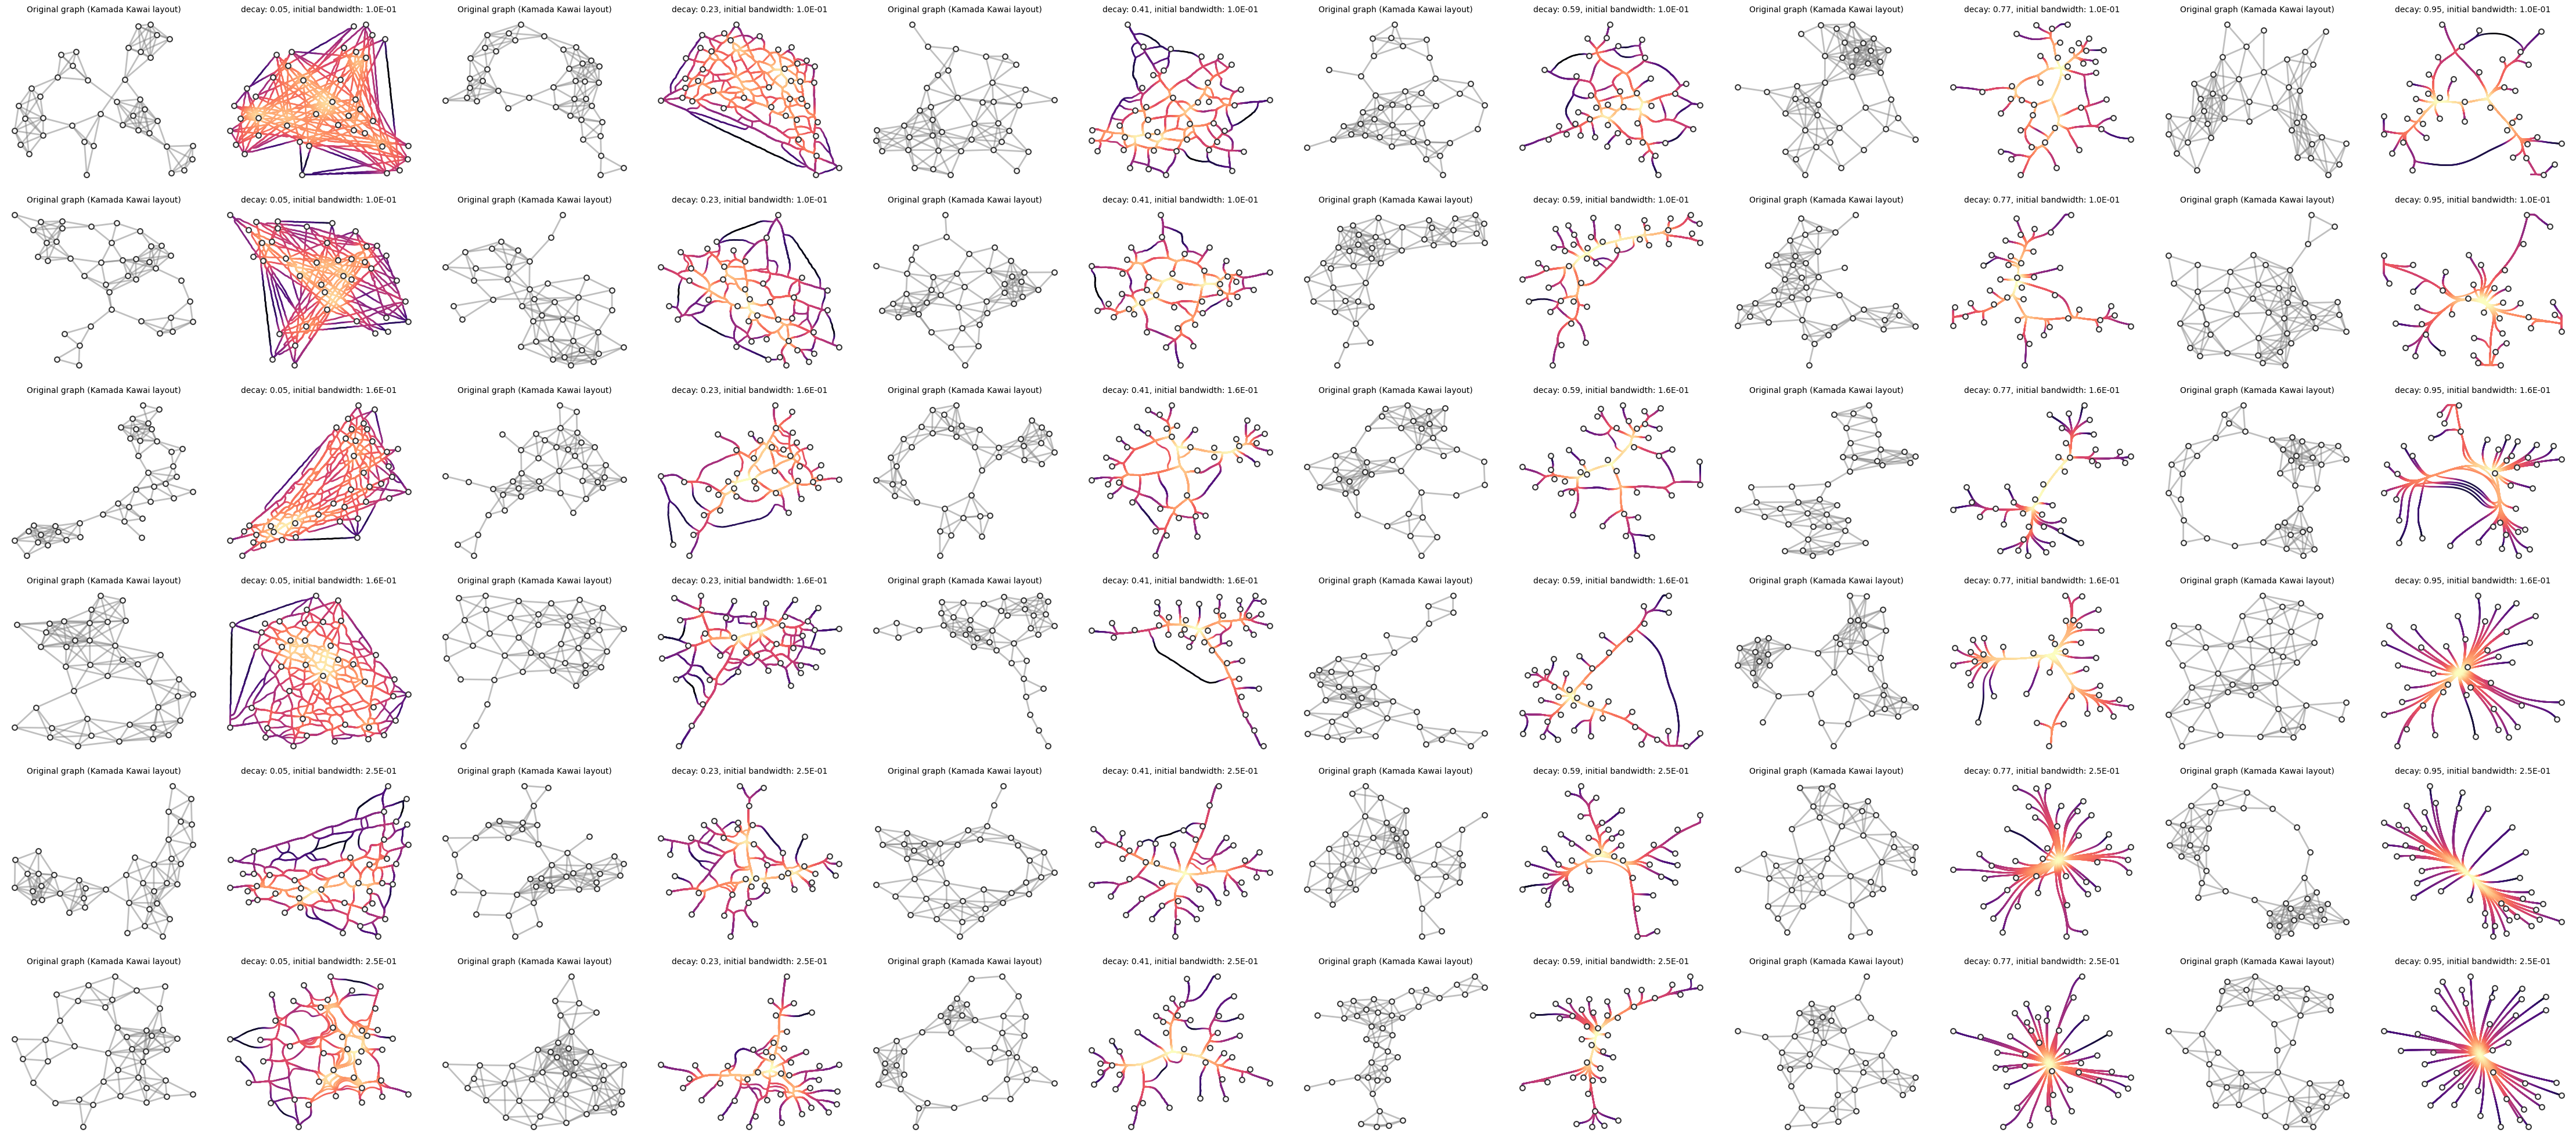

In [7]:
ncols = len(decays) * 2
nrows = len(ibs)
tups = list(it.product(range(nrows), range(ncols)))

fig, ax = plt.subplots(nrows,ncols,figsize=(ncols*4.75, nrows*4.25),dpi=100)
plt.subplots_adjust(hspace=0.15,wspace=0.1)

for i, a in enumerate(tups[::2]):
    print("%02i"%i, dt.datetime.now())
    hb = hbs[i]
    pos = pss[i]
    G = G_s[i]
    
    nx.draw_networkx_nodes(G, pos, node_color='w', edgecolors='.2',
                           zorder=20, node_size=40, ax=ax[a], linewidths=1.5)
    nx.draw_networkx_edges(G, pos, edge_color='.5', width=2, alpha=0.5, ax=ax[a])
    ax[a].set_axis_off()
    
    a1 = tups[1::2][i]
    
    nx.draw_networkx_nodes(G, pos, node_color='w', edgecolors='.2',
                           zorder=20, node_size=40, ax=ax[a1], linewidths=1.5)
    ras = ax[a1].scatter(hb['x'], hb['y'], s=4, lw=0, c=(hb['color'])**1.15,
               cmap='magma', vmax=hb['color'].max()*1.25, alpha=0.95,zorder=0)
    ax[a1].set_axis_off()
    ras.set_rasterized(True)
    ax[a1].set_axis_off()

    di = decays[(a1[1])//2]
    ibi = ibs[(a1[0])//2]
    ax[a1].set_title('decay: %.2f, initial bandwidth: %.1E'%(di,ibi),fontsize='medium')
    ax[a].set_title('Original graph (Kamada Kawai layout)',fontsize='medium')
    
plt.savefig('../figs/pngs/edge_bunde_many.png', dpi=600, bbox_inches='tight')

plt.show()

## Some fun art...

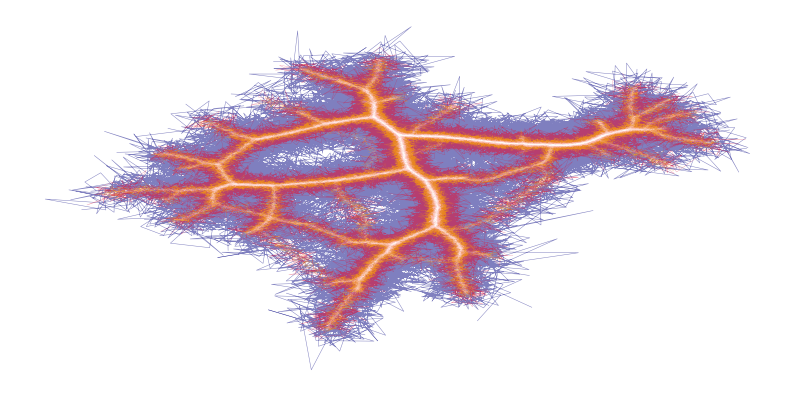

In [10]:
fig, ax = plt.subplots(1,1,dpi=100,figsize=(10,5))

lw = 0.35
sd = lw/5
num = 14

xvals = hbs[num]['x'] + np.random.normal(0, sd/1,len(hbs[num]['x']))
yvals = hbs[num]['y'] + np.random.normal(0, sd/1,len(hbs[num]['y']))
ax.plot(xvals, yvals, linewidth=lw/1, color='navy', alpha=0.5)

xvals = hbs[num]['x'] + np.random.normal(0, sd/2,len(hbs[num]['x']))
yvals = hbs[num]['y'] + np.random.normal(0, sd/2,len(hbs[num]['y']))
ax.plot(xvals, yvals, linewidth=lw/2, color='crimson', alpha=0.6)

xvals = hbs[num]['x'] + np.random.normal(0, sd/4,len(hbs[num]['x']))
yvals = hbs[num]['y'] + np.random.normal(0, sd/4,len(hbs[num]['y']))
ax.plot(xvals, yvals, linewidth=lw/4, color='orange', alpha=0.7)

xvals = hbs[num]['x'] + np.random.normal(0, sd/8,len(hbs[num]['x']))
yvals = hbs[num]['y'] + np.random.normal(0, sd/8,len(hbs[num]['y']))
ax.plot(xvals, yvals, linewidth=lw/8, color='pink', alpha=0.8)

xvals = hbs[num]['x'] + np.random.normal(0, sd/16,len(hbs[num]['x']))
yvals = hbs[num]['y'] + np.random.normal(0, sd/16,len(hbs[num]['y']))
ax.plot(xvals, yvals, linewidth=lw/16, color='w', alpha=0.9)

ax.set_axis_off()

plt.savefig('../figs/pngs/edge_bundle_art.png', dpi=900, bbox_inches='tight')

plt.show()